In [2]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Read in data:

In [5]:
#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('sub01/ocean.stats.nc', decode_times=False)
av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

xh= fs.xh.coarsen(xh=16, boundary="exact").mean()
yh = fs.yh.coarsen(yh=16, boundary="exact").mean()
Nlayers=15
Depth=fs.depth_ocean.coarsen(xh=16,yh=16, boundary="exact").mean()
rho  =os.Layer
rho= rho.Layer.rename({'Layer': 'zl'})

h  = (av['h'].coarsen(xh=16,yh=16, boundary="exact").mean()).mean('time').fillna(0.)
#Remove thin layers
h_masked = h.where(h >.1) 
mask = h_masked*0+1.
rho_3D=mask*rho

layer_pos = h_masked.cumsum(dim='zl')*mask
print(xh.shape)

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
available_diags.000000  longmean_00002050.nc         snapshots_00002705.nc
averages_00002002.nc    longmean_00002150.nc         static.nc
averages_00002102.nc    longmean_00002250.nc         sub01/
averages_00002202.nc    longmean_00002350.nc         sub02/
averages_00002302.nc    longmean_00002450.nc         sub03/
averages_00002402.nc    longmean_00002550.nc         sub04/
averages_00002502.nc    longmean_00002650.nc         sub04_sfc/
averages_00002602.nc    longmean_00002750.nc         sub05/
averages_00002702.nc    MOM_IC_1.nc                  sub05_sfc/
CPU_stats               MOM_IC_2.nc                  sub06/
diag_table@             MOM_IC.nc                    sub06_sfc/
diag_table.final        MOM_input@                   sub07/
diag_table.init         MOM_layout@                  sub07_sfc/
diag_table.sfc          MOM_override                 sub08/
exitcode                MOM_parameter_doc.all     

In [81]:
# ##Unparameterized run
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
# fs = xr.open_dataset('static.nc', decode_times=False)
# av =xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

# #Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15 
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test15
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.15  
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test24
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

# ## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0
# %cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
# fs=xr.open_dataset('static.nc', decode_times=False)
# av=xr.open_dataset('averages_00031502.nc',decode_times=False)

## MEKE_VISCOSITY_COEFF_KU = -0.0; MEKE_KHCOEFF = 0.5 
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
fs=xr.open_dataset('static.nc', decode_times=False)
av=xr.open_dataset('averages_00031502.nc',decode_times=False)


xh= fs.xh
yh = fs.yh
Nlayers=15
Depth=fs.depth_ocean
rho  =os.Layer
rho= rho.Layer.rename({'Layer': 'zl'})

h  = av['h'].mean('time').fillna(0.)
#Remove thin layers
h_masked = h.where(h >.1) 
mask = h_masked*0+1.
rho_3D=mask*rho

layer_pos = h_masked.cumsum(dim='zl')*mask
print(xh.shape)

/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
(120,)


[-1.21182683e-03  1.85788803e+00]
825.2004136268775


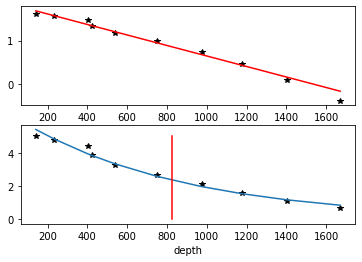

In [82]:
##Testing the curve fitting at one location

ind1 = 80
ind2 = 60

local_rho   = rho_3D[:,ind1,ind2].dropna('zl')
local_rho   = abs(local_rho-local_rho[-1])
local_layer = layer_pos[:,ind1,ind2].dropna('zl')

x = local_layer[:-2]
y = local_rho[:-2]
plt.subplot(2,1,1)
plt.plot(x,np.log(y),'*k')
A = np.polyfit(x,np.log(y),1,w=np.sqrt(y))
print(A)
plt.plot(x,A[1]+x*A[0],'r-')

plt.subplot(2,1,2)
#plt.title('12.5E, 50N')
plt.plot(x,y,'*k')
plt.plot(x,np.exp(A[1]+x*A[0]))
plt.plot([abs(1/A[0]),abs(1/A[0])],[0,np.max(y)],'r')
plt.xlabel('depth')
#plt.ylabel('buoyancy anomaly ($kg/m^3$)')
depth = np.abs(1/A[0])
print(depth)


In [83]:
##Curve fitting for all locations
depths = xr.zeros_like(rho_3D[0,:,:])
for i in range(yh.size):
    print(i)
    for j in range(xh.size):
        local_rho   = rho_3D[:,i,j].dropna('zl')
        if local_rho.size > 4:
            local_rho   = abs(local_rho-local_rho[-1])
            local_layer = layer_pos[:,i,j].dropna('zl')

            x = local_layer[:-2]
            y = local_rho[:-2]
            A = np.polyfit(x,np.log(y),1)
            depths[i,j] = np.abs(1/A[0])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [85]:
Depth_test1=Depth
depths_test1=depths

In [31]:
print(Depth)

<xarray.DataArray 'depth_ocean' (yh: 2240, xh: 960)>
[2150400 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2188 ... 59.84 59.91 59.97
  * yh       (yh) float64 -69.97 -69.91 -69.84 -69.78 ... 69.84 69.91 69.97
Attributes:
    long_name:      Depth of the ocean at tracer points
    units:          m
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: area_t
    standard_name:  sea_floor_depth_below_geoid


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


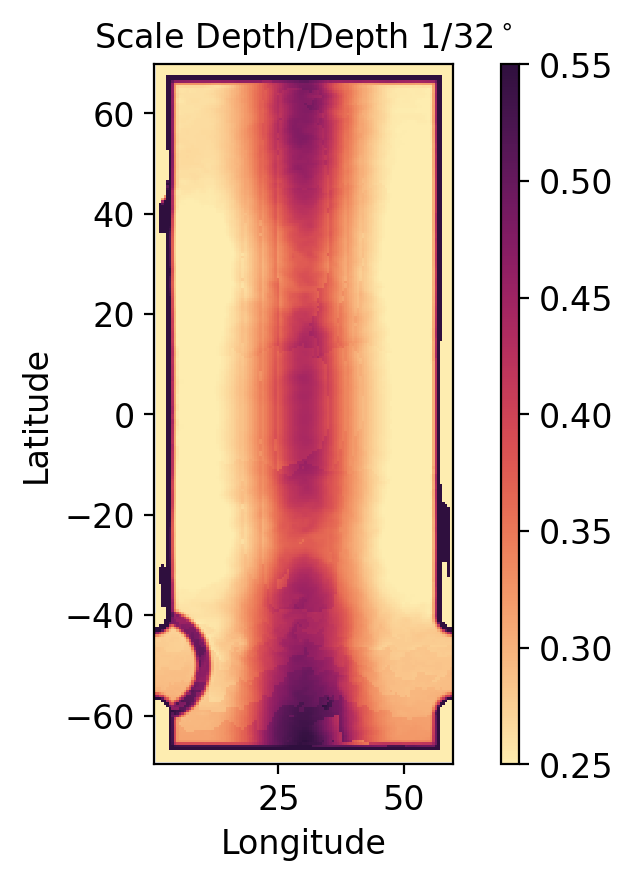

In [17]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Scale Depth/Depth 1/32$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh,yh,depths/Depth,cmap=cmocean.cm.matter,vmin=0.25,vmax=.55)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


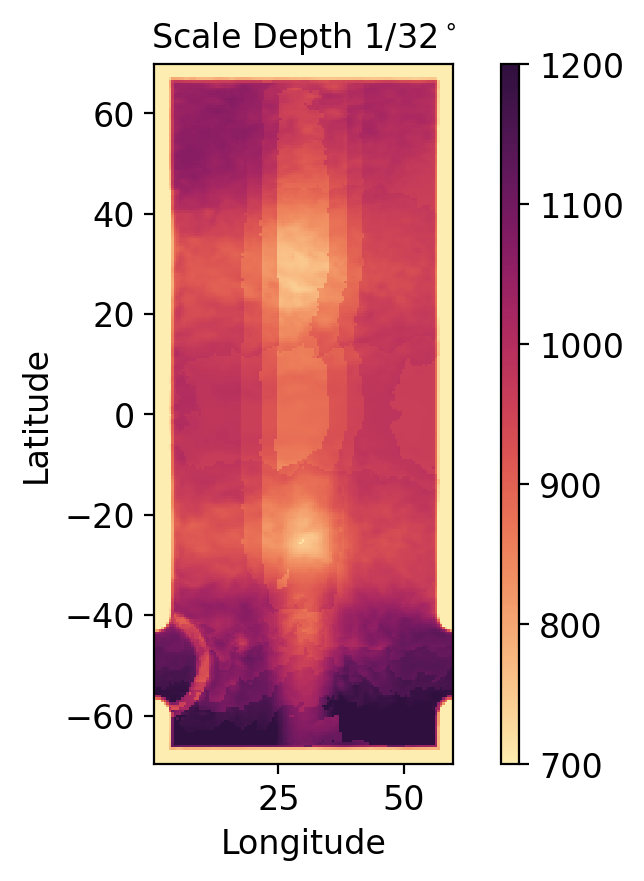

In [18]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Scale Depth 1/32$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh,yh,depths,cmap=cmocean.cm.matter,vmin=700,vmax=1200)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


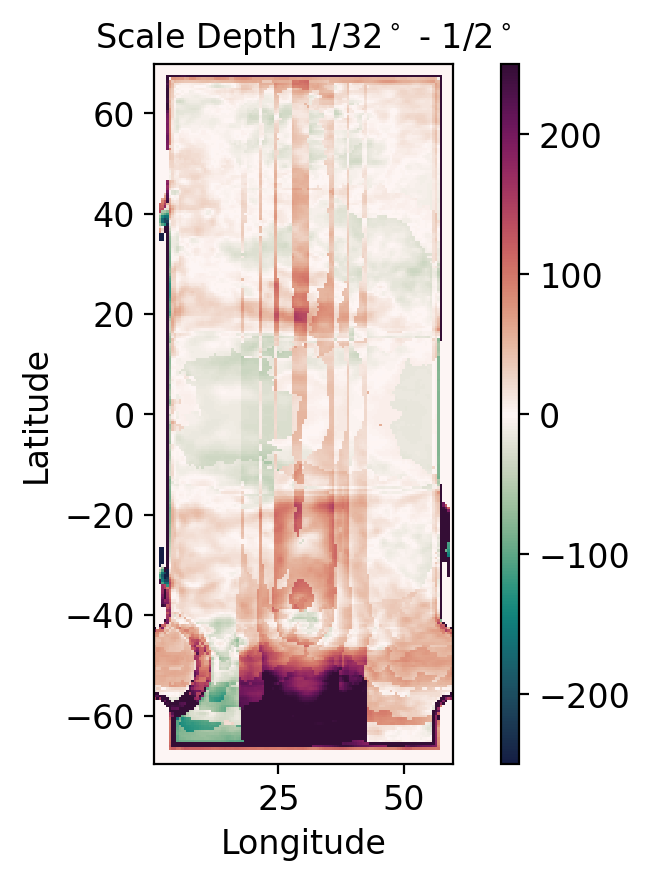

In [86]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Scale Depth 1/32$^\circ$ - 1/2$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh,yh,depths_003125-depths_test1,cmap=cmocean.cm.curl,vmin=-250,vmax=250)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

In [25]:
(depths_003125-depths_unparameterized).shape


(280, 120)

<xarray.DataArray 'xh' (xh: 120)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])
Coordinates:
    zl       float64 1.023e+03
  * xh       (xh) float64 0.25 0.75 1.25 1.75 2.25 ... 58.25 58.75 59.25 59.75